# Contexte

Ce notebook tente de résoudre le bug 245 :
https://github.com/dataforgoodfr/13_potentiel_solaire/issues/245

Pour rappel, les livrables sont :

* Estimer le nb / % d'établissements scolaires pour lesquels coordonnées & adresses semblent incohérents
* Script python avec la logique permettant l'amélioration de la qualité des données de l'annuaire
* Optionnel : migration alembic pour mettre à jour la base de données potentiel_solaire.duckdb (@machbry s'en occupera si besoin)


# Données

## Imports et fonctions d'appoint

Nous utilisons deux jeux de données :
1. celui contenant la géométrie (empreinte au sol) des bâtiments, provenant des zones d'éducation (un fichiers gpkg par département, prétraité par notre algorithme) ; il notamment contient l'identifiant de l'établissement, et un MULTIPOLYGON.
2. celui de l'annuaire des établissements scolaires, qui contient le même identifiant, une adresse (code postal, région, département...), et des coordonnées sous forme de POINT.

Après les imports nous définissons trois fonction d'appoint, respectivement pour créer une adresse en concaténant les colonnes correspondantes, d'une fonction de géocodage (utilisant l'excellent service de l'IGN), et d'un calcul de distance entre deux objets shapely, par défaut dans l'EPSG 6933 comme défini ici : https://outline.services.dataforgood.fr/doc/choix-du-crs-pour-les-calculs-de-distance-fFPOfhd1mi




In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import Point


import requests


pd.options.display.max_rows=200


lamb93="EPSG:2154"
wgs84="EPSG:4326"
projglob="EPSG:6933"

def cree_adresse(df: 'pd.DataFrame', cols: list[str] = None) -> 'pd.Series':
    """
    Construit une adresse complète à partir des colonnes spécifiées d'un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes d'adresse.
        cols (list[str], optional): Liste des noms de colonnes à utiliser pour l'adresse.
            Par défaut ["adresse_1", "code_postal", "nom_commune"].

    Returns:
        pd.Series: Série contenant les adresses concaténées.
    """
    if cols is None:
        cols = ["adresse_1", "code_postal", "nom_commune"]
    return df[cols].fillna(" ").apply(lambda x: ' '.join(x.values), axis=1)


def geocode(adresse: str) -> 'Point | None':
    """
    Géocode une adresse en utilisant l'API IGN (data.geopf.fr).

    Args:
        adresse (str): L'adresse à géocoder, typiquement obtenue via cree_adresse().

    Returns:
        Point | None: Un objet Point avec les coordonnées géographiques (WGS84) ou None si échec.
    """
    #time.sleep(0.1)
    r = requests.get(url="https://data.geopf.fr/geocodage/search",
                     params={"q": adresse})
    if not r.ok:
        return None
    try:
        js = r.json()
        return Point(js['features'][0]['geometry']['coordinates'])
    except:
        return None

def calcul_dist(df: 'pd.DataFrame', col1: str, col2: str, crs: str = projglob) -> 'pd.Series':
    """
    Calcule la distance entre deux colonnes de géométrie dans un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes de géométrie.
        col1 (str): Nom de la première colonne.
        col2 (str): Nom de la seconde colonne.
        crs (str, optional): Système de référence de coordonnées cible (projetées)
                             Par défaut EPSG:6933 (utilisée par le projet).

    Returns:
        pd.Series: Série contenant les distances calculées.
    """
    return gpd.GeoSeries(df[col1], crs="WGS84").to_crs(crs)\
        .distance(gpd.GeoSeries(df[col2], crs="WGS84").to_crs(crs))



## Nous commençons par les zones éducatives

On peut se contenter dans cette étude d'idcol (commune à l'annuaire), toponyme et geometry. 

La séparation en multipolygones rend possible, pour un même site, la présence de nombreux doublons. Nous en comptons 2200, et ne les considérerons pas à notre niveau d'analyse.

In [3]:
folder_path='../data/results/'
files = glob.glob(f"{folder_path}/D*.gpkg")
gdfs = [gpd.read_file(f, layer="educational_zones") for f in files]
gezraw=gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
gezraw

,identifiant_de_l_etablissement,cleabs_grande_zone,categorie,nature,toponyme,identifiants_sources,geometry
0,0230226W,SURFACTI0000002009254758,Science et enseignement,Enseignement primaire,None,['0230226W'],"MULTIPOLYGON (((1.93615 45.74959, 1.93577 45.7..."
1,0230225V,SURFACTI0000000247213643,Science et enseignement,Enseignement primaire,None,['0230225V'],"MULTIPOLYGON (((1.99581 45.78524, 1.99581 45.7..."
2,0230228Y,SURFACTI0000000247244004,Science et enseignement,Enseignement primaire,None,['0230228Y'],"MULTIPOLYGON (((2.12104 45.81014, 2.12104 45.8..."
3,0230080M,SURFACTI0000000256231128,Science et enseignement,Enseignement primaire,None,['0230080M'],"MULTIPOLYGON (((2.11902 45.92894, 2.11903 45.9..."
4,0230229Z,SURFACTI0000000247243980,Science et enseignement,Enseignement primaire,None,['0230229Z'],"MULTIPOLYGON (((2.06389 45.84632, 2.06404 45.8..."
...,...,...,...,...,...,...,...
52390,0400380W,SURFACTI0000000067286073,Science et enseignement,Enseignement primaire,None,['0400380W'],"MULTIPOLYGON (((-0.64064 43.78314, -0.64075 43..."
52391,0400914B,SURFACTI0000000067000842,Science et enseignement,Enseignement primaire,None,['0400914B'],"MULTIPOLYGON (((-0.70341 43.78651, -0.70384 43..."
52392,0400366F,SURFACTI0000000067002625,Science et enseignement,Enseignement primaire,None,['0400366F'],"MULTIPOLYGON (((-0.65514 43.79096, -0.65527 43..."
52393,0400378U,SURFACTI0000000067000935,Science et enseignement,Enseignement primaire,None,['0400378U'],"MULTIPOLYGON (((-0.60526 43.8154, -0.60528 43...."


In [4]:
idcol='identifiant_de_l_etablissement'

gez=gezraw[[idcol, "toponyme", "geometry"]]
gez

,identifiant_de_l_etablissement,toponyme,geometry
0,0230226W,None,"MULTIPOLYGON (((1.93615 45.74959, 1.93577 45.7..."
1,0230225V,None,"MULTIPOLYGON (((1.99581 45.78524, 1.99581 45.7..."
2,0230228Y,None,"MULTIPOLYGON (((2.12104 45.81014, 2.12104 45.8..."
3,0230080M,None,"MULTIPOLYGON (((2.11902 45.92894, 2.11903 45.9..."
4,0230229Z,None,"MULTIPOLYGON (((2.06389 45.84632, 2.06404 45.8..."
...,...,...,...
52390,0400380W,None,"MULTIPOLYGON (((-0.64064 43.78314, -0.64075 43..."
52391,0400914B,None,"MULTIPOLYGON (((-0.70341 43.78651, -0.70384 43..."
52392,0400366F,None,"MULTIPOLYGON (((-0.65514 43.79096, -0.65527 43..."
52393,0400378U,None,"MULTIPOLYGON (((-0.60526 43.8154, -0.60528 43...."


In [5]:
gez[gez[idcol].duplicated(keep=False)]

,identifiant_de_l_etablissement,toponyme,geometry
187,0320351H,None,"MULTIPOLYGON (((0.4144 43.58638, 0.4144 43.586..."
188,0320351H,None,"MULTIPOLYGON (((0.41253 43.58556, 0.41185 43.5..."
300,0320465G,None,"MULTIPOLYGON (((0.42997 43.80053, 0.42993 43.8..."
301,0320465G,None,"MULTIPOLYGON (((0.43027 43.80119, 0.43031 43.8..."
308,0320011N,Collège d'Éauze-Cazaubon,"MULTIPOLYGON (((0.09757 43.86007, 0.09855 43.8..."
...,...,...,...
52221,0400326M,Jean Rameau,"MULTIPOLYGON (((-1.10552 43.54494, -1.10546 43..."
52223,0400326M,Léo Lapeyre,"MULTIPOLYGON (((-1.10383 43.54531, -1.10381 43..."
52376,0400937B,École du Mas,"MULTIPOLYGON (((-0.27155 43.69212, -0.27162 43..."
52379,0400937B,Groupe Scolaire Françoise Giroud,"MULTIPOLYGON (((-0.26572 43.70279, -0.26573 43..."


In [6]:
gez=gez.drop_duplicates(subset=idcol)
gez

,identifiant_de_l_etablissement,toponyme,geometry
0,0230226W,None,"MULTIPOLYGON (((1.93615 45.74959, 1.93577 45.7..."
1,0230225V,None,"MULTIPOLYGON (((1.99581 45.78524, 1.99581 45.7..."
2,0230228Y,None,"MULTIPOLYGON (((2.12104 45.81014, 2.12104 45.8..."
3,0230080M,None,"MULTIPOLYGON (((2.11902 45.92894, 2.11903 45.9..."
4,0230229Z,None,"MULTIPOLYGON (((2.06389 45.84632, 2.06404 45.8..."
...,...,...,...
52390,0400380W,None,"MULTIPOLYGON (((-0.64064 43.78314, -0.64075 43..."
52391,0400914B,None,"MULTIPOLYGON (((-0.70341 43.78651, -0.70384 43..."
52392,0400366F,None,"MULTIPOLYGON (((-0.65514 43.79096, -0.65527 43..."
52393,0400378U,None,"MULTIPOLYGON (((-0.60526 43.8154, -0.60528 43...."


## Annuaire des établissements

Nous poursuivons avec l'annuaire.

Nous avons cette fois 7 paires de doublons ; ils ont même adresse et geometry, dans le contexte de cette étude nous pouvons les supprimer.

Une fois les doublons supprimés, nous créons un dataframe dfm fusionné sur la colonne idcol.



In [7]:
goodcols=[idcol, 'nom_etablissement','adresse_1', 'code_postal', 'nom_commune',
          'libelle_departement',  'libelle_region', 'geometry']
gann=gpd.read_file("../data/etablissements.geojson", columns=goodcols).sort_values(idcol)
gann

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry
51839,223 rue Alexandre Bérard,01505,0010001W,Ain,Auvergne-Rhône-Alpes,Ambérieu-en-Bugey,Lycée professionnel Alexandre Bérard,POINT (5.35024 45.97497)
33353,6 rue Aguetant,01500,0010002X,Ain,Auvergne-Rhône-Alpes,Ambérieu-en-Bugey,Collège Saint-Exupéry,POINT (5.35565 45.9624)
39057,131 rue de la Mairie,01380,0010005A,Ain,Auvergne-Rhône-Alpes,Bâgé-la-Ville,Collège Roger Poulnard,POINT (4.94599 46.31715)
33116,15 avenue Saint-Exupéry,01206,0010006B,Ain,Auvergne-Rhône-Alpes,Valserhône,Lycée polyvalent Saint-Exupéry,POINT (5.81829 46.11248)
50726,15 avenue Saint-Exupéry,01206,0010008D,Ain,Auvergne-Rhône-Alpes,Valserhône,Collège Saint-Exupéry,POINT (5.81829 46.11248)
...,...,...,...,...,...,...,...,...
10657,Rue du lycée professionnel de Kahani,97670,9760540H,Mayotte,Mayotte,Ouangani,Ecole maternelle publique Kahani 2,POINT (45.13024 -12.82386)
34717,Rue de la ferme,97615,9760541J,Mayotte,Mayotte,Dzaoudzi,Ecole primaire publique Labattoir 1 La Ferme,POINT (45.2791 -12.78891)
50553,None,97660,9760542K,Mayotte,Mayotte,Dembeni,Ecole maternelle publique de Iloni T7,POINT (45.18768 -12.84626)
30218,None,97660,9760543L,Mayotte,Mayotte,Dembeni,Ecole élémentaire publique de Iloni T12,POINT (45.18777 -12.84673)


In [8]:
gann.dropna(subset="geometry", inplace=True)
gann

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry
51839,223 rue Alexandre Bérard,01505,0010001W,Ain,Auvergne-Rhône-Alpes,Ambérieu-en-Bugey,Lycée professionnel Alexandre Bérard,POINT (5.35024 45.97497)
33353,6 rue Aguetant,01500,0010002X,Ain,Auvergne-Rhône-Alpes,Ambérieu-en-Bugey,Collège Saint-Exupéry,POINT (5.35565 45.9624)
39057,131 rue de la Mairie,01380,0010005A,Ain,Auvergne-Rhône-Alpes,Bâgé-la-Ville,Collège Roger Poulnard,POINT (4.94599 46.31715)
33116,15 avenue Saint-Exupéry,01206,0010006B,Ain,Auvergne-Rhône-Alpes,Valserhône,Lycée polyvalent Saint-Exupéry,POINT (5.81829 46.11248)
50726,15 avenue Saint-Exupéry,01206,0010008D,Ain,Auvergne-Rhône-Alpes,Valserhône,Collège Saint-Exupéry,POINT (5.81829 46.11248)
...,...,...,...,...,...,...,...,...
10657,Rue du lycée professionnel de Kahani,97670,9760540H,Mayotte,Mayotte,Ouangani,Ecole maternelle publique Kahani 2,POINT (45.13024 -12.82386)
34717,Rue de la ferme,97615,9760541J,Mayotte,Mayotte,Dzaoudzi,Ecole primaire publique Labattoir 1 La Ferme,POINT (45.2791 -12.78891)
50553,None,97660,9760542K,Mayotte,Mayotte,Dembeni,Ecole maternelle publique de Iloni T7,POINT (45.18768 -12.84626)
30218,None,97660,9760543L,Mayotte,Mayotte,Dembeni,Ecole élémentaire publique de Iloni T12,POINT (45.18777 -12.84673)


In [9]:
gann[gann.duplicated(subset=[idcol], keep=False)]

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry
47715,29 rue des Fontaines,29520,0292006Y,Finistère,Bretagne,Châteauneuf-du-Faou,Collège de l'Aulne,POINT (-3.81801 48.19083)
36519,29 rue des Fontaines,29520,0292006Y,Finistère,Bretagne,Spézet,Collège de l'Aulne - site de Spezet,POINT (-3.81801 48.19083)
39285,4 rue du 81e régiment d'infanterie,34090,0342266D,Hérault,Occitanie,Montpellier,Cité scolaire Françoise Combes (collège),POINT (3.87856 43.62052)
31739,4 rue du 81e régiment d'infanterie,34090,0342266D,Hérault,Occitanie,Montpellier,Cité scolaire Françoise Combes (lycée),POINT (3.87856 43.62052)
39245,2 place Gregoire de Tours,37012,0370039S,Indre-et-Loire,Centre-Val de Loire,Tours,Lycée Paul-Louis Courier (cycles du collège),POINT (0.69523 47.39589)
11402,2 place Gregoire de Tours,37012,0370039S,Indre-et-Loire,Centre-Val de Loire,Tours,Lycée Paul-Louis Courier,POINT (0.69523 47.39589)
33547,5 chemin de la Veillotière,61330,0611220V,Orne,Normandie,Passais Villages,Collège René Goscinny - site de Passais,POINT (-0.62542 48.49728)
31858,5 chemin de la Veillotière,61330,0611220V,Orne,Normandie,Ceaucé,Collège René Goscinny - site de Céaucé,POINT (-0.62542 48.49728)
38884,27 rue Edouard Pailleron,75019,0750711R,Paris,Ile-de-France,Paris,Lycée Henri Bergson (enseignement secondaire),POINT (2.37794 48.88112)
181,27 rue Edouard Pailleron,75019,0750711R,Paris,Ile-de-France,Paris,Lycée Henri Bergson (enseignement supérieur),POINT (2.37794 48.88112)


In [10]:
dfm=gann.merge(gez.rename(columns={"geometry": "polygon"}), on=idcol)
dfm["dist"]=calcul_dist(dfm, "geometry", "polygon")
dfm.sort_values("dist", inplace=True, ascending=False)
dfm["adresse"]=cree_adresse(dfm)
dfm

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry,toponyme,polygon,dist,adresse
32644,15 place de la mairie,69430,0690995G,Rhône,Auvergne-Rhône-Alpes,Deux-Grosnes,Ecole élémentaire,POINT (4.87483 46.68774),None,"MULTIPOLYGON (((4.60608 46.19473, 4.60592 46.1...",50768.611954,15 place de la mairie 69430 Deux-Grosnes
50089,Bourg de Pilima,97370,9730437M,Guyane,Guyane,Maripasoula,Ecole élémentaire Pilima,POINT (-54.02915 3.6405),École Élémentaire Pilima,"MULTIPOLYGON (((-54.10858 3.28739, -54.10858 3...",45614.990674,Bourg de Pilima 97370 Maripasoula
33569,13 grande rue,70000,0700630E,Haute-Saône,Bourgogne-Franche-Comté,Montigny-lès-Vesoul,Ecole primaire,POINT (6.07342 47.63808),None,"MULTIPOLYGON (((6.53304 47.72232, 6.53344 47.7...",44941.862681,13 grande rue 70000 Montigny-lès-Vesoul
6794,Route de Bordeaux,17136,0171157R,Charente-Maritime,Nouvelle-Aquitaine,Saintes,École d'enseignement technique de l'armée de l...,POINT (-0.28864 45.44424),École d'Enseignement Technique de l'Armée de l...,"MULTIPOLYGON (((-0.63006 45.70575, -0.63317 45...",40225.377265,Route de Bordeaux 17136 Saintes
49990,Bourg de Cayode,97370,9730202G,Guyane,Guyane,Maripasoula,Ecole élémentaire Cayodé,POINT (-54.03022 3.64403),École Primaire Kayodé,"MULTIPOLYGON (((-53.92691 3.3899, -53.92681 3....",33851.362093,Bourg de Cayode 97370 Maripasoula
...,...,...,...,...,...,...,...,...,...,...,...,...
28157,3 rue d'en Haut,62860,0620618K,Pas-de-Calais,Hauts-de-France,Palluel,Ecole primaire Jean-François Lemaire,POINT (3.10062 50.26677),École Primaire Jean-François Lemaire,"MULTIPOLYGON (((3.10117 50.26655, 3.10129 50.2...",0.000000,3 rue d'en Haut 62860 Palluel
28158,13 rue de la Viéville,62860,0620622P,Pas-de-Calais,Hauts-de-France,Sauchy-Cauchy,Ecole élémentaire RPI 84,POINT (3.0973 50.23561),None,"MULTIPOLYGON (((3.09717 50.23549, 3.09731 50.2...",0.000000,13 rue de la Viéville 62860 Sauchy-Cauchy
28159,15 GRAND'RUE,62860,0620624S,Pas-de-Calais,Hauts-de-France,Quéant,Ecole maternelle,POINT (2.98498 50.17936),None,"MULTIPOLYGON (((2.98513 50.17909, 2.98512 50.1...",0.000000,15 GRAND'RUE 62860 Quéant
28160,60 rue Joffre,62860,0620626U,Pas-de-Calais,Hauts-de-France,Rumaucourt,Ecole primaire RPI 158,POINT (3.0597 50.24239),None,"MULTIPOLYGON (((3.05978 50.24229, 3.05955 50.2...",0.000000,60 rue Joffre 62860 Rumaucourt


# Statistiques des écarts

L'on cherche à savoir s'il y a une coupure nette des distances entre une identification correcte et une qui ne l'est pas.

Pour ce faire, nous regardons les distributions associées (classique et cumulée)


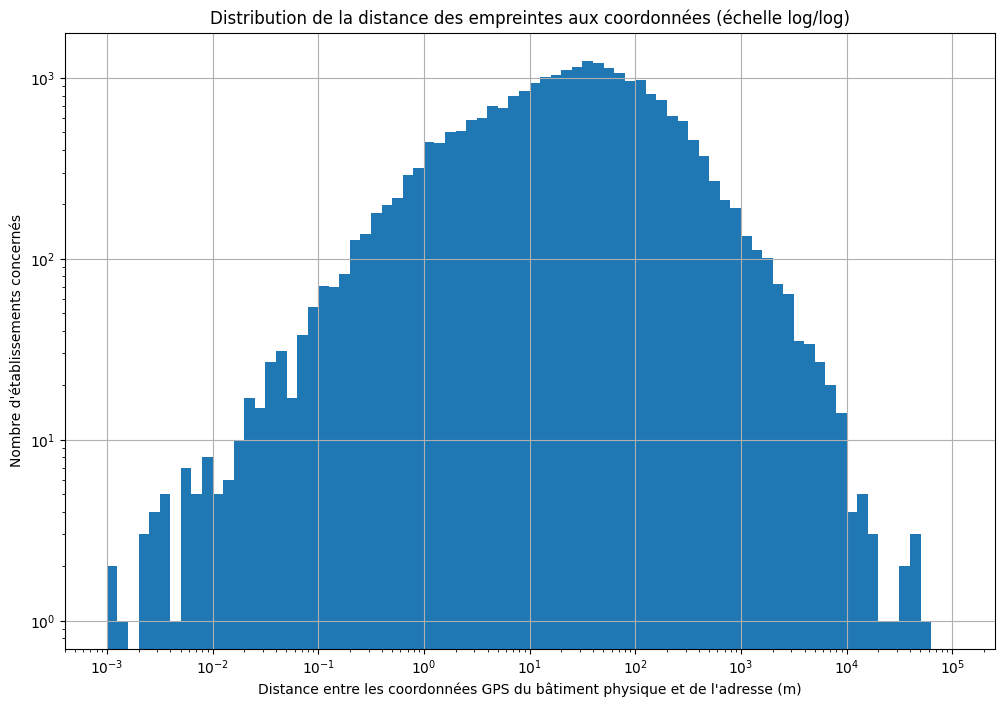

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
bins=np.logspace(-3, 5, 81)
plt.hist(dfm.dist, bins=bins)
plt.xlabel("Distance entre les coordonnées GPS du bâtiment physique et de l'adresse (m)")
plt.ylabel("Nombre d'établissements concernés")
plt.title("Distribution de la distance des empreintes aux coordonnées (échelle log/log)")
ax.loglog()
ax.grid()

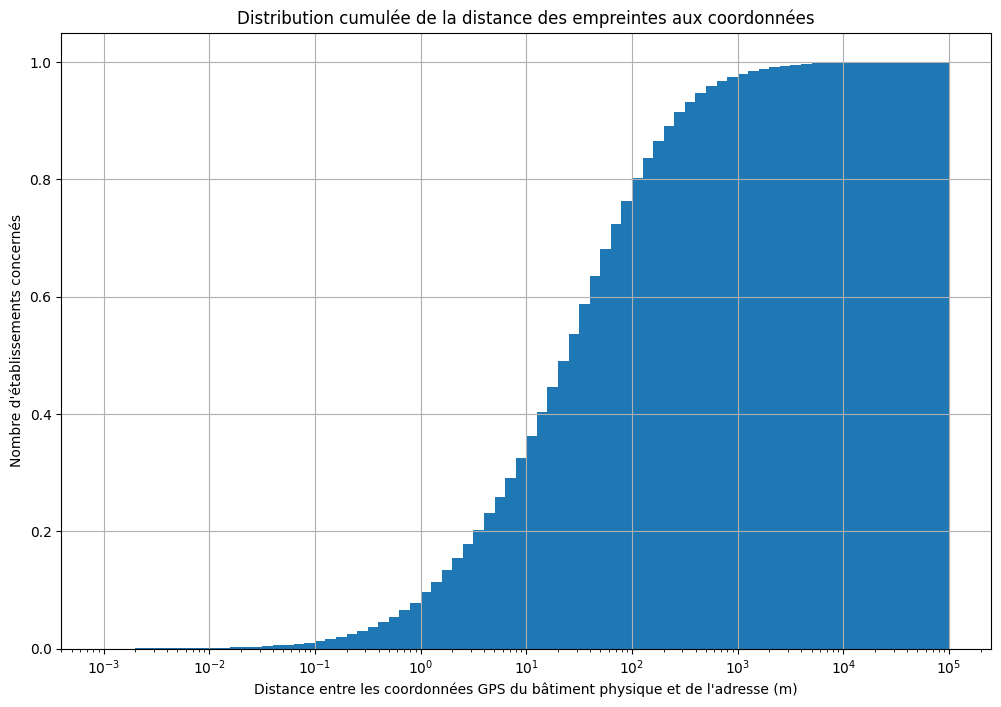

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(dfm.dist, bins=bins, cumulative=True, density=True)
plt.xlabel("Distance entre les coordonnées GPS du bâtiment physique et de l'adresse (m)")
plt.ylabel("Nombre d'établissements concernés")
plt.title("Distribution cumulée de la distance des empreintes aux coordonnées")
ax.grid()
ax.set_xscale('log')


(100, 100000.0)

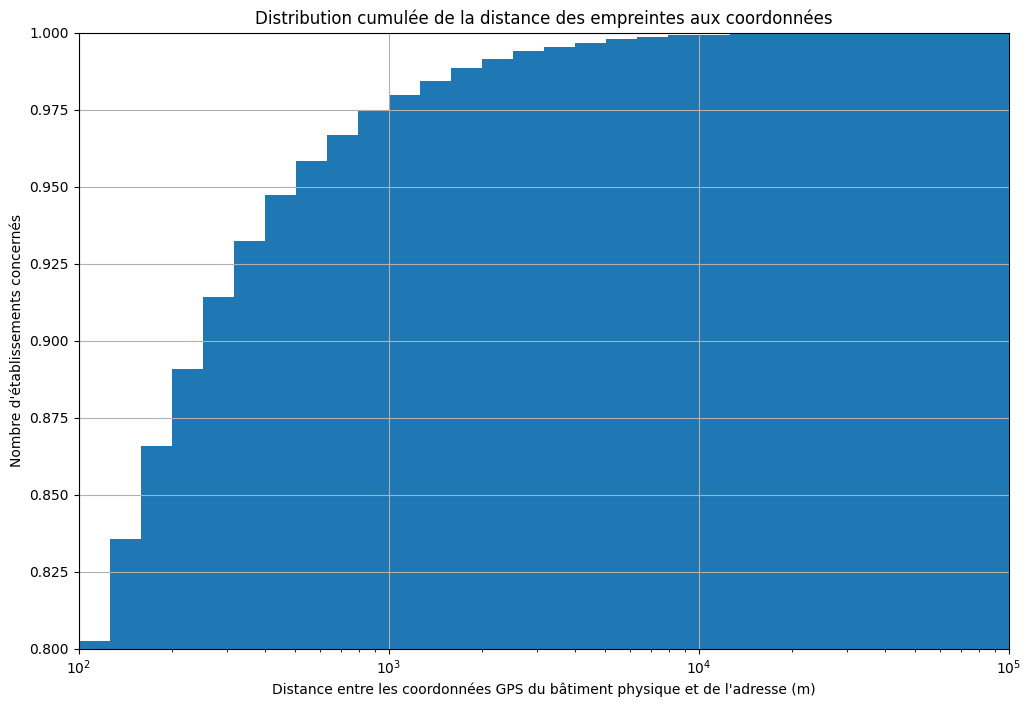

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(dfm.dist, bins=bins, cumulative=True, density=True)
plt.xlabel("Distance entre les coordonnées GPS du bâtiment physique et de l'adresse (m)")
plt.ylabel("Nombre d'établissements concernés")
plt.title("Distribution cumulée de la distance des empreintes aux coordonnées")
ax.grid()
ax.set_xscale('log')
ax.set_ylim(0.8, 1)
ax.set_xlim(100, 1e5)

On observe une distribution monomodale des distances, centrée à quelques dizaines de mètres.

Les distributions cumulées confirment ce diagnostic : environ 50% des établissements à une distance inférieure à une vingtaine de mètres, 80% à 100 mètres, 920% à 250m, 2.5 % à 1 km, et peut-être un millième au-delà de 10 km.

Il faut fixer un seuil au-delà duquel on estimera qu'il y a un problème. Une solution devra alors être envisagée. Nous suggérons 300m, ce qui correspond tout de même près de 10 % des établissements.

Nous regardons s'il existe des différences au sein des régions et départements ; nous trions par distance au troisième quartile (le pire quart des établissements au-dessus de cette valeur).


In [18]:
dfm.groupby("libelle_region")["dist"].describe().sort_values("75%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
libelle_region,,,,,,,,
Guadeloupe,321.0,393.462939,587.671147,0.0,58.414876,191.085312,477.676304,5138.973424
Martinique,284.0,351.379305,739.287504,0.0,0.000000,62.894528,367.592748,5178.921634
Guyane,234.0,982.813785,4648.350018,0.0,0.000000,41.543737,280.566661,45614.990674
Corse,282.0,397.103818,1403.842916,0.0,0.000000,20.087693,201.547071,18137.187374
La Réunion,640.0,328.600299,1395.629445,0.0,0.000000,10.251790,83.816443,16289.445472
Mayotte,263.0,146.976127,599.648057,0.0,0.000000,3.558811,50.408623,7708.823480
Provence-Alpes-Côte d'Azur,3359.0,82.911299,626.372621,0.0,0.000000,0.000000,40.065035,31530.549264
Normandie,2730.0,100.858861,641.195673,0.0,0.000000,1.447255,39.442922,17407.320827
Auvergne-Rhône-Alpes,6168.0,85.341163,756.197820,0.0,0.000000,0.000000,31.700521,50768.611954


In [19]:
dfm.groupby("libelle_departement")["dist"].describe().sort_values("75%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
libelle_departement,,,,,,,,
Guadeloupe,321.0,393.462939,587.671147,0.0,58.414876,191.085312,477.676304,5138.973424
Martinique,284.0,351.379305,739.287504,0.0,0.000000,62.894528,367.592748,5178.921634
Haute-Corse,159.0,390.729068,1064.500528,0.0,0.000000,11.527111,295.054801,7647.909643
Guyane,234.0,982.813785,4648.350018,0.0,0.000000,41.543737,280.566661,45614.990674
Lot,203.0,351.378364,1097.460776,0.0,0.000000,6.595597,142.381804,9182.638676
Savoie,437.0,224.887045,856.373951,0.0,2.114989,33.105374,138.034029,12808.410966
Corse-du-Sud,123.0,405.344347,1752.593967,0.0,0.000000,29.271347,103.258942,18137.187374
Var,621.0,169.312054,1290.114837,0.0,2.241043,34.641544,101.335296,31530.549264
Vaucluse,422.0,112.763299,270.340762,0.0,0.000000,23.901596,92.838650,2403.171717


Les DROM, en particulier la Guadeloupe (50% supérieurs à 200 m), se distinguent par des écarts élevés, mais aucune région n'est épargnée et toutes ont des établissements plus loin qu'un kilomètre de leurs coordonnées.

Après confirmation sur osm, les bâtiments de quelques établissements sont bien placés, mais ce sont les coordonnées GPS qui ne correspondent pas à la réalité.

# Exemple de la git issue et géocodage

Nous reprenons l'exemple du lycée Germaine Tillion.

Nous observons bien l'écart constaté d'un kilomètre.

En géocodant l'adresse, on obtient des coordonnées plus proches de celles du polygone.

Est-ce qu'un géocodage des établissements où la distance est la plus grande serait la solution ?

In [21]:
idgermaine='0110012D'
dfgermaine=dfm.query(f"{idcol}=='{idgermaine}'").iloc[0].copy()
dfgermaine

adresse_1                                                 Avenue du Docteur Laennec
code_postal                                                                   11493
identifiant_de_l_etablissement                                             0110012D
libelle_departement                                                            Aude
libelle_region                                                            Occitanie
nom_commune                                                           Castelnaudary
nom_etablissement                                 Lycée polyvalent Germaine Tillion
geometry                                POINT (1.948869504160203 43.31733940114656)
toponyme                                                     Lycée Germaine Tillion
polygon                           MULTIPOLYGON (((1.9388481864047684 43.30530845...
dist                                                                     1138.29453
adresse                               Avenue du Docteur Laennec 11493 Castel

In [22]:
print()

POINT (1.940132 43.306754)


In [22]:
dfgermaine["geocode"]=geocode(dfgermaine.adresse)

In [25]:
calcul_dist(dfgermaine, "polygon", "geocode")

0    9.544672
dtype: float64

En l'espèce, cela se passe beaucoup mieux : géocoder de nouveau l'adresse permet de la faire coller à la position des bâtiments.

Pour savoir si cela généralise, nous sélectionnons au hasard dix établissements dans chaque département, pour avoir une variété ; les biais d'échantillonnage seraient intéressants à discuter, mais ça sera pour une autre fois ;)



In [29]:
dfsamp=dfm.groupby("libelle_departement").sample(10).copy()

In [30]:
geocodes=dfsamp.adresse.apply(geocode)
geocodes

141      POINT (5.596891 46.017438)
159       POINT (5.356267 45.94465)
282      POINT (5.687884 45.875017)
244      POINT (5.024026 46.121446)
370      POINT (5.698737 45.759041)
                    ...            
39575     POINT (1.579692 48.96443)
39393    POINT (2.123355 48.795788)
39391     POINT (2.125527 48.80671)
39174    POINT (1.909493 49.010228)
39747    POINT (2.018816 48.979384)
Name: adresse, Length: 1010, dtype: object

In [32]:
dfsamp["geocodes"]=geocodes
dfsamp["dist2"]=calcul_dist(dfsamp, "polygon", "geocodes")

dfsamp

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry,toponyme,polygon,dist,adresse,geocodes,dist2
141,60 place de la mairie,01110,0010404J,Ain,Auvergne-Rhône-Alpes,Champdor-Corcelles,Ecole primaire,POINT (5.59689 46.01744),None,"MULTIPOLYGON (((5.59749 46.01769, 5.59751 46.0...",29.156689,60 place de la mairie 01110 Champdor-Corcelles,POINT (5.596891 46.017438),29.100796
159,Route de Saint Denis,01500,0010448G,Ain,Auvergne-Rhône-Alpes,Bettant,Ecole primaire,POINT (5.36223 45.94337),None,"MULTIPOLYGON (((5.36276 45.94347, 5.36275 45.9...",0.000000,Route de Saint Denis 01500 Bettant,POINT (5.356267 45.94465),579.947931
282,1 rue de l'Arvière,01510,0010794H,Ain,Auvergne-Rhône-Alpes,Artemare,Collège du Valromey,POINT (5.68724 45.87505),Collège du Valromey,"MULTIPOLYGON (((5.68727 45.87508, 5.68727 45.8...",0.000000,1 rue de l'Arvière 01510 Artemare,POINT (5.687884 45.875017),58.989004
244,52 route de Chatillon,01400,0010681K,Ain,Auvergne-Rhône-Alpes,Romans,Ecole élémentaire,POINT (5.02385 46.12161),None,"MULTIPOLYGON (((5.02389 46.12163, 5.02389 46.1...",0.000000,52 route de Chatillon 01400 Romans,POINT (5.024026 46.121446),18.164692
370,84 A rue Guillaume Gianinetto,01300,0011067E,Ain,Auvergne-Rhône-Alpes,Belley,Collège Sabine Zlatin,POINT (5.69922 45.75904),Collège Sabine Zlatin,"MULTIPOLYGON (((5.69925 45.75906, 5.69925 45.7...",0.000000,84 A rue Guillaume Gianinetto 01300 Belley,POINT (5.698737 45.759041),43.139787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39575,12 rue des Tilleuls,78200,0781431G,Yvelines,Ile-de-France,Boissy-Mauvoisin,Ecole primaire,POINT (1.57969 48.96443),École Élémentaire de Boissy-Mauvoisin,"MULTIPOLYGON (((1.57957 48.96482, 1.57922 48.9...",7.514042,12 rue des Tilleuls 78200 Boissy-Mauvoisin,POINT (1.579692 48.96443),7.507946
39393,3 bis rue Saint Louis,78000,0781028U,Yvelines,Ile-de-France,Versailles,Ecole élémentaire Jean-Baptiste de la Quintinie,POINT (2.12335 48.79579),École Élémentaire J B de la Quintinie,"MULTIPOLYGON (((2.12358 48.79613, 2.12343 48.7...",0.000000,3 bis rue Saint Louis 78000 Versailles,POINT (2.123355 48.795788),0.000000
39391,01 rue Carnot,78000,0781026S,Yvelines,Ile-de-France,Versailles,Ecole élémentaire Carnot,POINT (2.12553 48.80671),École Élémentaire Carnot,"MULTIPOLYGON (((2.12573 48.8067, 2.12587 48.80...",3.676908,01 rue Carnot 78000 Versailles,POINT (2.125527 48.80671),3.659231
39174,Route de Pontoise,78250,0780571X,Yvelines,Ile-de-France,Meulan-en-Yvelines,Collège Henri IV,POINT (1.90955 49.01023),Collège Henri IV,"MULTIPOLYGON (((1.92354 49.01359, 1.92365 49.0...",945.675700,Route de Pontoise 78250 Meulan-en-Yvelines,POINT (1.909493 49.010228),951.167588


In [42]:
import colorcet as cc
cmap=cc.glasbey
dfsamp["dpt"]=dfsamp.code_postal.astype(int)//1000
dfsamp["color"]=dfsamp["dpt"].apply(lambda x: cmap[x])
dfsamp

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry,toponyme,polygon,dist,adresse,geocodes,dist2,dpt,color
141,60 place de la mairie,01110,0010404J,Ain,Auvergne-Rhône-Alpes,Champdor-Corcelles,Ecole primaire,POINT (5.59689 46.01744),None,"MULTIPOLYGON (((5.59749 46.01769, 5.59751 46.0...",29.156689,60 place de la mairie 01110 Champdor-Corcelles,POINT (5.596891 46.017438),29.100796,1,#8c3bff
159,Route de Saint Denis,01500,0010448G,Ain,Auvergne-Rhône-Alpes,Bettant,Ecole primaire,POINT (5.36223 45.94337),None,"MULTIPOLYGON (((5.36276 45.94347, 5.36275 45.9...",0.000000,Route de Saint Denis 01500 Bettant,POINT (5.356267 45.94465),579.947931,1,#8c3bff
282,1 rue de l'Arvière,01510,0010794H,Ain,Auvergne-Rhône-Alpes,Artemare,Collège du Valromey,POINT (5.68724 45.87505),Collège du Valromey,"MULTIPOLYGON (((5.68727 45.87508, 5.68727 45.8...",0.000000,1 rue de l'Arvière 01510 Artemare,POINT (5.687884 45.875017),58.989004,1,#8c3bff
244,52 route de Chatillon,01400,0010681K,Ain,Auvergne-Rhône-Alpes,Romans,Ecole élémentaire,POINT (5.02385 46.12161),None,"MULTIPOLYGON (((5.02389 46.12163, 5.02389 46.1...",0.000000,52 route de Chatillon 01400 Romans,POINT (5.024026 46.121446),18.164692,1,#8c3bff
370,84 A rue Guillaume Gianinetto,01300,0011067E,Ain,Auvergne-Rhône-Alpes,Belley,Collège Sabine Zlatin,POINT (5.69922 45.75904),Collège Sabine Zlatin,"MULTIPOLYGON (((5.69925 45.75906, 5.69925 45.7...",0.000000,84 A rue Guillaume Gianinetto 01300 Belley,POINT (5.698737 45.759041),43.139787,1,#8c3bff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39575,12 rue des Tilleuls,78200,0781431G,Yvelines,Ile-de-France,Boissy-Mauvoisin,Ecole primaire,POINT (1.57969 48.96443),École Élémentaire de Boissy-Mauvoisin,"MULTIPOLYGON (((1.57957 48.96482, 1.57922 48.9...",7.514042,12 rue des Tilleuls 78200 Boissy-Mauvoisin,POINT (1.579692 48.96443),7.507946,78,#8c54b1
39393,3 bis rue Saint Louis,78000,0781028U,Yvelines,Ile-de-France,Versailles,Ecole élémentaire Jean-Baptiste de la Quintinie,POINT (2.12335 48.79579),École Élémentaire J B de la Quintinie,"MULTIPOLYGON (((2.12358 48.79613, 2.12343 48.7...",0.000000,3 bis rue Saint Louis 78000 Versailles,POINT (2.123355 48.795788),0.000000,78,#8c54b1
39391,01 rue Carnot,78000,0781026S,Yvelines,Ile-de-France,Versailles,Ecole élémentaire Carnot,POINT (2.12553 48.80671),École Élémentaire Carnot,"MULTIPOLYGON (((2.12573 48.8067, 2.12587 48.80...",3.676908,01 rue Carnot 78000 Versailles,POINT (2.125527 48.80671),3.659231,78,#8c54b1
39174,Route de Pontoise,78250,0780571X,Yvelines,Ile-de-France,Meulan-en-Yvelines,Collège Henri IV,POINT (1.90955 49.01023),Collège Henri IV,"MULTIPOLYGON (((1.92354 49.01359, 1.92365 49.0...",945.675700,Route de Pontoise 78250 Meulan-en-Yvelines,POINT (1.909493 49.010228),951.167588,78,#8c54b1


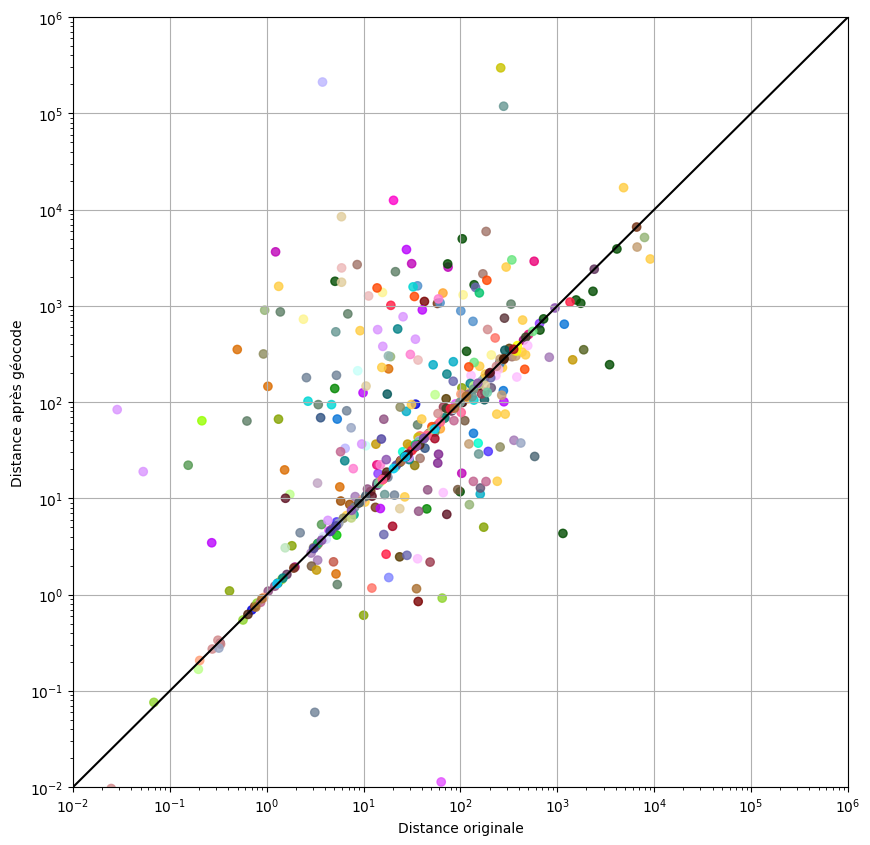

In [54]:
import matplotlib.pyplot as plt
import colorcet as color

fig, ax=plt.subplots(figsize=(10, 10))
plt.scatter(dfsamp.dist, dfsamp.dist2, color=dfsamp.color, alpha=0.8)
p1, p2=(1e-2, 1e6)
plt.axline((p1, p1), (p2, p2) , color="k")

ax.loglog()
ax.set_xlabel("Distance originale")
ax.set_ylabel("Distance après géocode")
ax.set_xlim(p1, p2)
ax.set_ylim(p1, p2)
ax.grid()

# Analyse et recommandation

On observe un bel effet de régression à la moyenne : les points initialement loin sont statistiquement plus proches après géocodage (les points sous la droite ont une abscisse élevée), et les points initialement proches sont plus distants (les points d'abscisse faible sont au-dessus de la courbe).

La décision n'est pas évidente. On pourrait, pour les établissements initialement distants, voir si un géocodage réduit la distance, auquel cas prendre cette nouvelle position pour la carte.

Ou bien partir du centroïde des positions de l'empreinte des bâtiments (qui semble systématiquement fiable, empiriquement et par construction) défini comme point indiqué sur la carte. On pourrait envisager un géocoding inverse, mais cela soulèverait sans doute plus de questions en cas d'écart constaté par les utilisateurs à l'adresse réelle que de garder l'adresse connue et d'en déplacer les coordonnées.

Une fonction proposée, utilisant les fonctions d'appoint déjà définies, et partant d'un dataframe mergé, pourrait avoir cette allure :



In [72]:
def reduction_ecarts(df: 'pd.DataFrame', seuil: int = 300) -> None:
    """
    Réduit les écarts de géolocalisation en optimisant les points selon la distance à un polygone.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes 'geometry' et 'polygon'.
        seuil (int, optional): Seuil de distance pour optimisation. Par défaut 300.

    Modifie le DataFrame en ajoutant les colonnes:
        - 'dist': distance entre 'geometry' et 'polygon'
        - 'adresse': adresse concaténée
        - 'optim_geo': géométrie optimisée
        - 'optim_dist': distance entre 'polygon' et 'optim_geo'
        - 'final_pt': point final optimisé
    """
    df["dist"] = calcul_dist(df, "geometry", "polygon")
    df["adresse"] = cree_adresse(df)
    df["optim_geo"] = df.apply(lambda x: x["geometry"] if x["dist"] < seuil else geocode(x["adresse"]), axis=1)
    df["optim_dist"] = calcul_dist(df, "polygon", "optim_geo")
    df["final_pt"] = df.apply(lambda x: x["optim_geo"] if x["optim_dist"] < seuil else x["polygon"].centroid, axis=1)
    return df

dft=dfm.sample(100).copy()
dft=reduction_ecarts(dft)
dft

,adresse_1,code_postal,identifiant_de_l_etablissement,libelle_departement,libelle_region,nom_commune,nom_etablissement,geometry,toponyme,polygon,dist,adresse,seuil,optim_geo,optim_dist,final_pt
22748,Rue Louis Pergaud,54520,0540621G,Meurthe-et-Moselle,Grand Est,Laxou,Ecole maternelle Louis Pergaud,POINT (6.1425 48.68543),École Maternelle Louis Pergaud,"MULTIPOLYGON (((6.1429 48.68534, 6.14273 48.68...",0.000000,Rue Louis Pergaud 54520 Laxou,False,POINT (6.1425 48.68543),0.000000,POINT (6.1425 48.68543)
11374,Rue Jean Jaurès,30960,0300020J,Gard,Occitanie,Le Martinet,Collège Antoine Deparcieux,POINT (4.08464 44.25283),Collège Antoine Deparcieux,"MULTIPOLYGON (((4.0848 44.25336, 4.08482 44.25...",30.801881,Rue Jean Jaurès 30960 Le Martinet,False,POINT (4.08464 44.25283),30.801881,POINT (4.08464 44.25283)
35648,6 bis rue du Lachat,74940,0741458H,Haute-Savoie,Auvergne-Rhône-Alpes,Annecy,Ecole élémentaire publique Le Lachat Annecy-Le...,POINT (6.1466 45.92175),École Élémentaire le Lachat,"MULTIPOLYGON (((6.14633 45.92125, 6.14598 45.9...",0.000000,6 bis rue du Lachat 74940 Annecy,False,POINT (6.1466 45.92175),0.000000,POINT (6.1466 45.92175)
48849,10 rue du 11 Novembre,95110,0951711U,Val-d'Oise,Ile-de-France,Sannois,Ecole primaire la Belle Etoile,POINT (2.25823 48.97302),École Primaire la Belle Étoile,"MULTIPOLYGON (((2.25742 48.97323, 2.25751 48.9...",0.000000,10 rue du 11 Novembre 95110 Sannois,False,POINT (2.25823 48.97302),0.000000,POINT (2.25823 48.97302)
8672,BOURG,24190,0240235A,Dordogne,Nouvelle-Aquitaine,Chantérac,Ecole élémentaire,POINT (0.44437 45.17262),None,"MULTIPOLYGON (((0.44419 45.1726, 0.44449 45.17...",0.000000,BOURG 24190 Chantérac,False,POINT (0.44437 45.17262),0.000000,POINT (0.44437 45.17262)
33623,Place Jeanne d'Arc,70210,0700900Y,Haute-Saône,Bourgogne-Franche-Comté,Passavant-la-Rochère,Ecole primaire du Centre,POINT (6.03552 47.96917),École Primaire du Centre,"MULTIPOLYGON (((6.03503 47.96881, 6.03491 47.9...",56.473957,Place Jeanne d'Arc 70210 Passavant-la-Rochère,False,POINT (6.03552 47.96917),56.473957,POINT (6.03552 47.96917)
22937,15 allée de Fribourg,54500,0541430L,Meurthe-et-Moselle,Grand Est,Vandoeuvre-lès-Nancy,Ecole maternelle Jeanne d'Arc,POINT (6.17526 48.65854),École Maternelle Jeanne d'Arc,"MULTIPOLYGON (((6.17503 48.65895, 6.17512 48.6...",0.000000,15 allée de Fribourg 54500 Vandoeuvre-lès-Nancy,False,POINT (6.17526 48.65854),0.000000,POINT (6.17526 48.65854)
4991,Boulevard Henri Barbusse,13110,0132398L,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Port-de-Bouc,Ecole maternelle Louise Michel,POINT (4.99102 43.40755),École Maternelle Louise Michel,"MULTIPOLYGON (((4.99163 43.40712, 4.99164 43.4...",0.000000,Boulevard Henri Barbusse 13110 Port-de-Bouc,False,POINT (4.99102 43.40755),0.000000,POINT (4.99102 43.40755)
45346,Avenue de Dordogne,91940,0912112B,Essonne,Ile-de-France,Les Ulis,Section d'enseignement professionnel du lycée ...,POINT (2.16614 48.6768),Lycée l'Essouriau,"MULTIPOLYGON (((2.1634 48.67534, 2.16418 48.67...",12.628018,Avenue de Dordogne 91940 Les Ulis,False,POINT (2.16614 48.6768),12.628018,POINT (2.16614 48.6768)
28281,48 rue des Ecoles,62340,0621027E,Pas-de-Calais,Hauts-de-France,Andres,Ecole primaire Les sources bleues,POINT (1.9217 50.86575),École Primaire les Sources Bleues,"MULTIPOLYGON (((1.92098 50.86568, 1.92102 50.8...",0.000000,48 rue des Ecoles 62340 Andres,False,POINT (1.9217 50.86575),0.000000,POINT (1.9217 50.86575)
